<h1>Agent Based Modeling with Python (mesa) </h1>

    
**Creator**: Sean Fronczak

**Date**: 4/20/19

**TLDR**: Using a toy economic model from mesa's online documentation, I demonstrate the fundamentals of creating, analyzing, and manipulating the governing protocol for an agent based model in Python.  Assuming I'm trying to optimize for equal wealth distribution within the system, I manipulate the framework of the system and analyze the effects on the agents' wealth disparity (using Monte Carlo simulation).

**Packages used**: mesa, numpy, pandas, scipy, matplotlib, seaborn

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Example-Model" data-toc-modified-id="Example-Model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Example Model</a></span><ul class="toc-item"><li><span><a href="#Creating-a-class-of-model-objects" data-toc-modified-id="Creating-a-class-of-model-objects-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Creating a class of model objects</a></span></li><li><span><a href="#Creating-a-class-of-agent-objects" data-toc-modified-id="Creating-a-class-of-agent-objects-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Creating a class of agent objects</a></span></li><li><span><a href="#Observe-the-Agents-moving-around-the-grid" data-toc-modified-id="Observe-the-Agents-moving-around-the-grid-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Observe the Agents moving around the grid</a></span></li><li><span><a href="#Analyze-the-economic-disparity-in-the-results" data-toc-modified-id="Analyze-the-economic-disparity-in-the-results-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Analyze the economic disparity in the results</a></span></li></ul></li><li><span><a href="#Manipulate-the-System" data-toc-modified-id="Manipulate-the-System-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Manipulate the System</a></span><ul class="toc-item"><li><span><a href="#Remove-Movement/Grid-for-Faster-Computation" data-toc-modified-id="Remove-Movement/Grid-for-Faster-Computation-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Remove Movement/Grid for Faster Computation</a></span><ul class="toc-item"><li><span><a href="#Modify-the-class-for-a-gridless-model" data-toc-modified-id="Modify-the-class-for-a-gridless-model-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Modify the class for a gridless model</a></span></li><li><span><a href="#Create-new-class-for-stationary-agents" data-toc-modified-id="Create-new-class-for-stationary-agents-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Create new class for stationary agents</a></span></li><li><span><a href="#Verify-the-Wealth-Inequality-still-exists-in-the-gridless-model" data-toc-modified-id="Verify-the-Wealth-Inequality-still-exists-in-the-gridless-model-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Verify the Wealth Inequality still exists in the gridless model</a></span></li></ul></li><li><span><a href="#Changing-the-initial-wealth" data-toc-modified-id="Changing-the-initial-wealth-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Changing the initial wealth</a></span><ul class="toc-item"><li><span><a href="#Monte-Carlo-Simulation:--Initial-Ageant-wealth-=-1" data-toc-modified-id="Monte-Carlo-Simulation:--Initial-Ageant-wealth-=-1-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Monte Carlo Simulation:  Initial Ageant wealth = 1</a></span></li><li><span><a href="#Monte-Carlo-Simulation:--Variable-Initial-Agent-Wealth" data-toc-modified-id="Monte-Carlo-Simulation:--Variable-Initial-Agent-Wealth-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Monte Carlo Simulation:  Variable Initial Agent Wealth</a></span><ul class="toc-item"><li><span><a href="#Run-for-longer-time-steps-(allow-to-stabilize)" data-toc-modified-id="Run-for-longer-time-steps-(allow-to-stabilize)-2.2.2.1"><span class="toc-item-num">2.2.2.1&nbsp;&nbsp;</span>Run for longer time steps (allow to stabilize)</a></span></li></ul></li></ul></li></ul></li></ul></div>

## Example Model

I will implement this simple model then show how to use the OOP structure of Python and the mesa library to analyze/manipulate the different aspects of an Agent Based Model (ABM) in an OOP environment. The model was adopted from mesa's introductory example.  The full explanation of the model can be found here:

https://mesa.readthedocs.io/en/master/tutorials/intro_tutorial.html#building-a-sample-model

**Key takeaway**: This model creates a framework that leads to great wealth disparity amongst the agents.  Later we will see if we can tweak the model to address this.

In [1]:
# first some imports
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
import random
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats

import warnings
warnings.filterwarnings('ignore')

Before creating the model, let us define our measure of wealth equality as the gini index

In [2]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
    return (1 + (1/N) - 2*B)

### Creating a class of model objects

We begin by creating a class that "inherits" from mesa's "Model" class and naming it: "MoneyModel."  The MoneyModel model class will be used an the "environment" where agents can interact and behave according to rules that we specify.  

For this example, the model is initiated by:
1. Creating a toroidal grid of specified size (using mesa's MultiGrid class)
2. Creating a specified number of agents, N, and randomly placing them on the grid
3. Initializing the scheduler (activates the agents once and turn in a random order)
4. Specifying the type of data that we would like to collect (in this case the gini index and agent wealth)

In [3]:
# A model is specified by number of agents in the model and dims of the grid (it's a toroid)
class MoneyModel(Model):
    """A mesa model with N agents are initiated randomly on a toroidal grid of specified width/height.
    The scheduler is of the RandomActivation class which selects agents in a random order each round.
    The data is collected at both the agent level and model level at each step."""
    
    
    def __init__(self, N, width, height):
        """Creating the grid, scheduler and agents"""
        
        # create the grid based on mesa's MultiGrid class
        self.grid = MultiGrid(width, height, True)
        
        # This controls in what order the agents work
        self.schedule = RandomActivation(self)
        
        # Create agents and add them to the grid
        self.num_agents = N
        for i in range(self.num_agents):
            # assign an id to each agent
            a = MoneyAgent(i, self)
            # add the agent to the schedule list
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
            
        # initiate datacollector class and specify data to be collected
        self.datacollector = DataCollector(
                            model_reporters={"Gini": compute_gini},  # A function to call (see below)
                            agent_reporters={"Wealth": "wealth"})  # An agent attribute
    

    def step(self):
        """Defining the actions to take at each step"""
        
        self.datacollector.collect(self)
        self.schedule.step()

### Creating a class of agent objects

Now we need to define the agent class and the rules that govern their movements. This simple example allows agents to do two things:
1. Exchange money with a neighbor
2. Move around a grid

The rules are:
1. At each step, the agents are initiated in a random order (changing each round)
2. The agent moves to a random space, then looks around for a neighbor
3. If a neighbor exists and the agent has at least 1 money token, he gives it to one of the neighbors

In [4]:
class MoneyAgent(Agent):
    def __init__(self, unique_id, model):
        """ An agent with fixed initial wealth."""
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        """Randomly choose a direction and move one cell"""
        possible_steps = self.model.grid.get_neighborhood(self.pos, 
                                                          moore=True,
                                                          include_center=False)
        new_position = random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
    
    
    def give_money(self):
        '''This first checks for neighbors to give money to, then gives to 1 random
        if the agent has wealth>1 to give'''
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1
    
    def step(self):
        """At each step, each agent moves once and gives 1 token if they have it"""
        self.move()
        if self.wealth > 0:
            self.give_money()

### Observe the Agents moving around the grid

In order to visualize how the agents move around the grid, let's initiate a model and use a heatmap to show how many agents are on each cell in the grid as we step through time (note that more than one agent can be in a cell at a time)

1. Initiate the model on a 10x10 grid with 50 agents

In [5]:
model = MoneyModel(50, 10, 10)

2. Visualize where the agents have been randomly placed (note that more than one agent can be in the same cell at a time).

**Note: A lighter region implies a higher the concentration of agents**

In [6]:
# I like seaborn's heatmap package
import seaborn as sns 

def count_agents(model):
    agent_counts = np.zeros((model.grid.width, model.grid.height))
    for cell in model.grid.coord_iter():
        cell_content, x, y = cell
        agent_count = len(cell_content)
        agent_counts[x][y] = agent_count
    return agent_counts

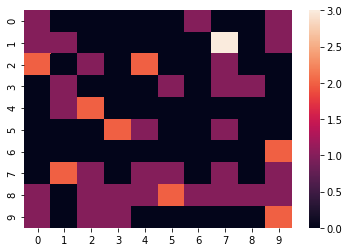

In [7]:
sns.heatmap(count_agents(model))

3. Step through one time step in the simulation (let the agents all randomly choose one space to move)

In [8]:
model.step()

4. Visualize the updated placement of the agents (note the toroidal nature of the grid, the top/bottom wrap to connect as well as the left/right so agents are free to move between those regions)

Text(0.5,0.98,'Agent Location')

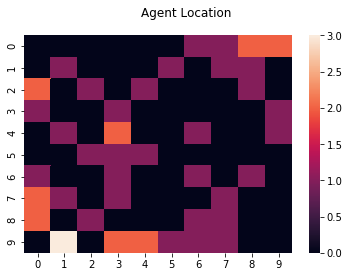

In [9]:
sns.heatmap(count_agents(model))
plt.suptitle('Agent Location')

### Analyze the economic disparity in the results

1. Run the model for 500 time steps

In [10]:
# yeah the call to run the model is this simple once you've set it up properly
for i in range(500):
    model.step()

2. Note the distribution of wealth after running the full model

**Only a few agents have all the money and almost 50% of the agents have no money!!**

Text(0.5,0.98,'Distribution of Agent Wealth after Simulation')

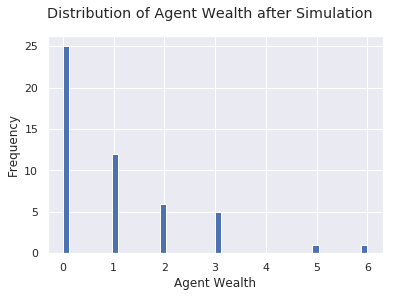

In [11]:
sns.set()
agent_wealth = [a.wealth for a in model.schedule.agents]
plt.hist(agent_wealth,50)
plt.xlabel('Agent Wealth'); plt.ylabel('Frequency'); 
plt.suptitle('Distribution of Agent Wealth after Simulation')

3. Temporal Analysis

Using the gini index as a measure of wealth equality (0 being perfectly equal and 1 meaning that a single agent has all the wealth), we see that the simulation begins (at time = 0) with perfect equality and quickly jumps to a steady state of gini = 0.7 (after as little as 50 time steps).

Text(0.5,0.98,'Distribution of Agent Wealth with respect to Time')

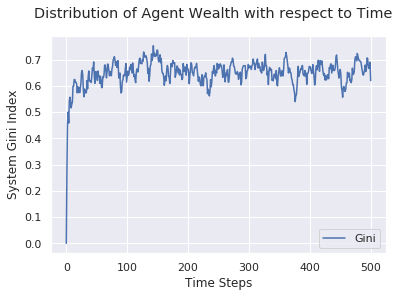

In [12]:
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()
plt.xlabel('Time Steps'); plt.ylabel('System Gini Index'); 
plt.suptitle('Distribution of Agent Wealth with respect to Time')

## Manipulate the System

Most of the above was recreated from the mesa example docs.  But now let's look at how easy it is to mess with the model system and analyze it to optimize for, say, equal distribution of wealth amongst agents.

**Manipulate the model**

Now we want to see if we can somehow create a system which distributes the wealth more evenly amongst it's agents. We will do this by modifying the original system and then running a Monte Carlo simulation to test the affect of a changing the agents' initial wealth on the overall system equality.


**But first...**

Monte Carlo simulations can take a lot of computational time to complete.  Since I'm using my personal computer and really just want to play around, let's imagine we are working with a system where the agents can interact with one another regardless of their physical location (i.e. over the internet).

Therefore the new rule is that at each step, each agent gives 1 token to ANY other random agent. We therefore must create two new classes for model's and agents

### Remove Movement/Grid for Faster Computation

Let's create this system then verify that this new system is similarly unbalanced in terms of wealth.

#### Modify the class for a gridless model

We will call it the "Gridless_Model"

We will add one more parameter which is the agents' starting wealth

In [13]:
class Gridless_Model(Model):
    """A mesa model with N agents are initiated.
    The scheduler is of the RandomActivation class which selects agents in a random order each round.
    The data is collected at both the agent level and model level at each step."""
    
    def __init__(self, N, initial_wealth):
        """Creating scheduler and agents"""

        # Scheduler controls in what order the agents work
        self.schedule = RandomActivation(self)
        
        # Create agents and add them to the grid
        self.num_agents = N
        for i in range(self.num_agents):
            # assign an id to each agent
            a = Stationary_Agent(i, initial_wealth,self)
            # add the agent to the schedule list
            self.schedule.add(a)
            
        # initiate datacollector class and specify data to be collected
        self.datacollector = DataCollector(
                            model_reporters={"Gini": compute_gini},  # A function to call (see below)
                            agent_reporters={"Wealth": "wealth"})  # An agent attribute
    
    def step(self):
        """Defining the actions to take at each step"""
        
        self.datacollector.collect(self)
        self.schedule.step()

#### Create new class for stationary agents

We will call it the "Stationary_Agent"

Again, now we can explicitly specify the wealth the agent begins with (instead of the previous example where it was always 1)

In [14]:
class Stationary_Agent(Agent):
    def __init__(self, unique_id,initial_wealth, model):
        """ An agent with fixed initial wealth."""
        super().__init__(unique_id, model)
        self.wealth = initial_wealth
    
    def step(self):
        """Gives a token to a random agent if the agent has it to give"""
        if self.wealth == 0:
            return
        other_agent = random.choice(self.model.schedule.agents)
        other_agent.wealth += 1
        self.wealth -= 1

#### Verify the Wealth Inequality still exists in the gridless model

As you can see, over 50% of the agents still end up with 0 tokens after 500 time steps and the gini index shoots up (even faster now) to a steady state somewhere between 0.6 and 0.7

Thus, this system also has a pattern of wealth inequality.

In [15]:
model = Gridless_Model(50,1)
for i in range(500):
    model.step()

Text(0.5,0.98,'Distribution of Agent Wealth after Simulation')

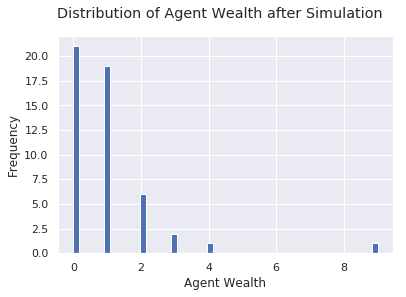

In [16]:
sns.set()
agent_wealth = [a.wealth for a in model.schedule.agents]
plt.hist(agent_wealth,50)
plt.xlabel('Agent Wealth'); plt.ylabel('Frequency'); 
plt.suptitle('Distribution of Agent Wealth after Simulation')

Text(0.5,0.98,'Distribution of Agent Wealth with respect to Time')

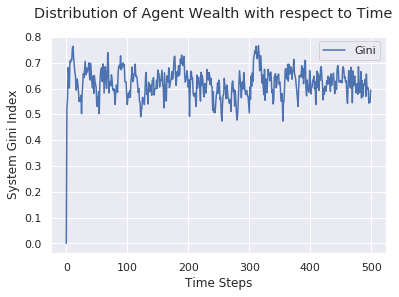

In [17]:
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()
plt.xlabel('Time Steps'); plt.ylabel('System Gini Index'); 
plt.suptitle('Distribution of Agent Wealth with respect to Time')

### Changing the initial wealth

Recall that we can now specify the initial wealth for our agents when we initiate the model. So let's see how changing this affects the state of equality of our system.

**Hypothesis**: When the agents start with only one token and give up a token each round, the chances that many of them won't be able to participate as the simulation progresses is high.  Without participants, the exchange of tokens diminishes and thus, the wealth inequality cannot be augmented.

**Disclaimer**:

I only investigate this parameter but of course I could've also looked into several other parameter/rule changes such as:
- changing the number of agents
- implementing a new rule where those with great wealth are forced to give up more money each turn (this would create several more parameters to be optimized)
- create an incentive for those with greater wealth to trade more (or vice versa for the poorer agents)

Implementing any of these changes would be a simple change in the source code for the classes I defined above for the model and agents.

#### Monte Carlo Simulation:  Initial Ageant wealth = 1

Note that before we'd only been running one simulation. But what if we were curious for a generalized view of the system's behavior under the preset protocol?  We can use the Monte Carlo framework to sample the system many times and then report summary statistics based on the results (expected behavior and confidence in this estimate).

1. Run the Model

The variance inherent of this simple model so small that the confidence intervals are very tight even with only 100 iterations through the MC simulation.  Therefore, there is no apparent need to increase the sample size.

In [18]:
# initial parameters
initial_wealth = 1
num_agents = 50
time_steps = 100
mc_iters = 100

# make array keep track of the final wealth of each agent and gini index of each run
agent_wealths = np.zeros((num_agents,mc_iters))
ginis = np.zeros((time_steps,mc_iters))

for j in range(mc_iters):
    # create a model
    model = Gridless_Model(num_agents,initial_wealth)
    # step through the simulation
    for i in range(time_steps):
        model.step()
    
    # add the gini index information from each run to an array
    ginis[:,j] = model.datacollector.get_model_vars_dataframe().Gini.values
    
    # add the agent wealth distribution to final counts
    agent_wealth = [a.wealth for a in model.schedule.agents]
    agent_wealths[:,j]=agent_wealth

2. Visualize wealth histogram of all simulations combined

Same as before with more agents so it's a bit smoother (starting to see the true behavior of the system)

Text(0.5,0.98,'Distribution of Agent Wealth after Simulation')

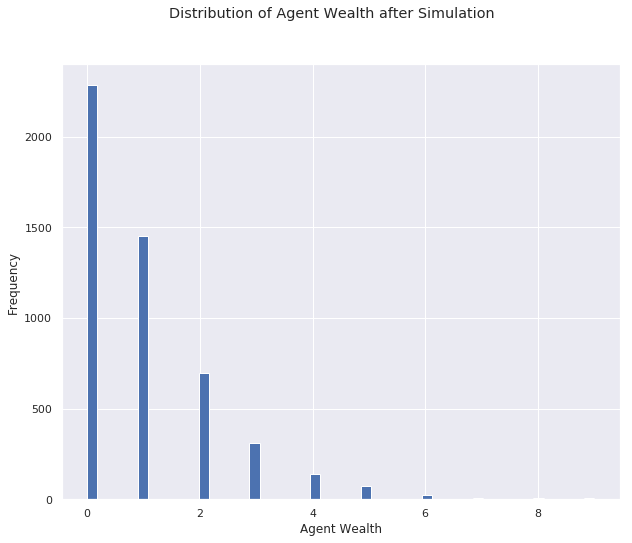

In [19]:
fig = plt.figure(figsize=(10, 8))
sns.set()
wealth = pd.DataFrame(agent_wealths)
wealth.stack().hist(bins=50)
plt.xlabel('Agent Wealth'); plt.ylabel('Frequency'); 
plt.suptitle('Distribution of Agent Wealth after Simulation')

3. Visualize the temporal gini index

Again, confidence intervals are included but are quite tight since the model is so simple

In [20]:
import scipy.stats

# function to calculate confidence interval of a pandas row
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return round(m,4), round(m-h,4), round(m+h,4)

Text(0.5,0.98,'Distribution of Agent Wealth with Respect to Time')

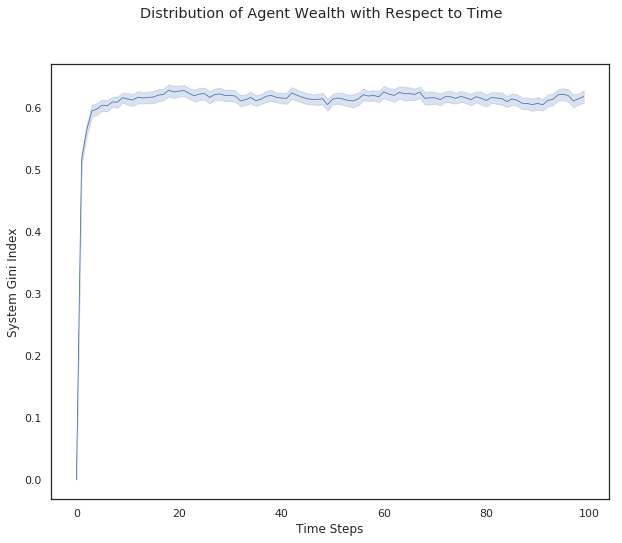

In [21]:
# gather into a dataframe
ginis = pd.DataFrame(ginis)
# create confidence band
ginis['mean'],  ginis['low'], ginis['high'] = zip(*ginis.apply(mean_confidence_interval,axis=1))

# create plot
sns.set_style("white")
fig = plt.figure(figsize=(10, 8))
plt.plot(ginis['mean'],linewidth=0.8,color='b')

# add in confidence interval
plt.fill_between(ginis.index, ginis['low'], ginis['high'], color='b', alpha=.2)

# plot labels
plt.xlabel('Time Steps'); plt.ylabel('System Gini Index'); 
plt.suptitle('Distribution of Agent Wealth with Respect to Time')

#### Monte Carlo Simulation:  Variable Initial Agent Wealth

Now let's repeat the same simulation but for a few different initial wealth settings: 1, 5, 10, 100.

We realize that this is really just a surrogate for the ratio of how much an agent gives with respect to their initial worth (i.e. if they start with 100 and only give 1 per round).

Note that we now need to create a 3D tensor to collect the data from all the simulations and eventually plot the results in the following cells

In [22]:
# initial parameters
initial_wealths = [1,5,10,100]
num_agents = 50
time_steps = 100
mc_iters = 100

# make 3D tensor to track of the final wealth of each agent and gini index of each run
# for each initial wealth
agent_wealths = np.zeros((len(initial_wealths),num_agents,mc_iters))
model_ginis = np.zeros((len(initial_wealths),time_steps,mc_iters))


for k in range(len(initial_wealths)):
    initial_wealth = initial_wealths[k]
    for j in range(mc_iters):
        # create a model
        model = Gridless_Model(num_agents,initial_wealth)
        # step through the simulation
        for i in range(time_steps):
            model.step()

        # add the gini index information from each run to an array
        model_ginis[k,:,j] = model.datacollector.get_model_vars_dataframe().Gini.values

        # add the agent wealth distribution to final counts
        agent_wealth = [a.wealth for a in model.schedule.agents]
        agent_wealths[k,:,j]=agent_wealth

**Results (part 1)**

And now we can see that there is a bit of a descrepancy between the final wealth states of the different models after 100 simulations.  Initial wealth of 1, 5, and 10 take on the characteristic shape from before.  The key difference of course is that these new models still have agents who are able to keep participating in the system even though they are poor (thus more tokens are exchanged per turn in the 5 and 10 sytems).  Moreover, **having an initial wealth of 100 appears to be more balanced!!**  Let's look at the gini index to see why...

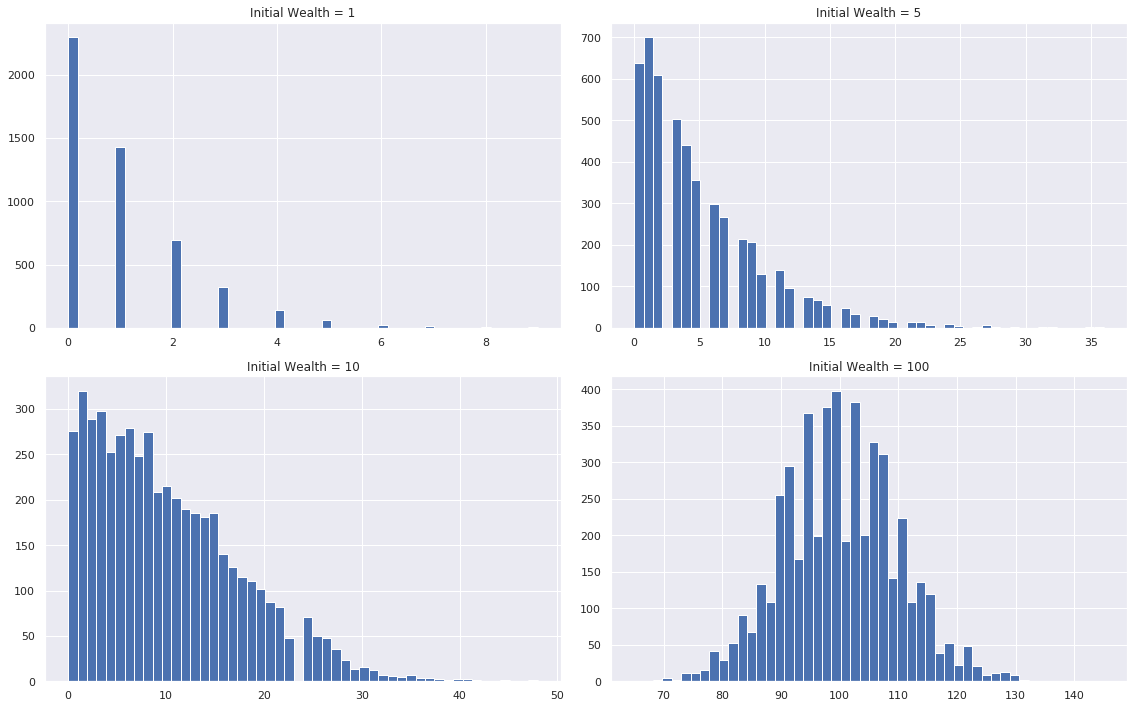

In [23]:
fig = plt.figure(figsize=(16, 10))

sns.set()
for c,num in zip(initial_wealths, range(1,5)):
    wealth = pd.DataFrame(agent_wealths[num-1])
    ax = fig.add_subplot(2,2,num)
    wealth.stack().hist(bins=50)
    ax.set_title(f'Initial Wealth = {c}')
    
plt.tight_layout()

**Gini Results (part 1)**

After looking at these gini index plots, I wonder if the simulation just simply didn't run for enough time steps for the model to stabilize into a steady state for the higher initial wealths.

The obvious trend appears to be that the higher the initial wealth, the more balanced the equality remains (although, as seen above, the separation between haves/have-nots is still present).  This is a very important finding if you are interested in developing a system where the maximum amount of agents are able to participate.

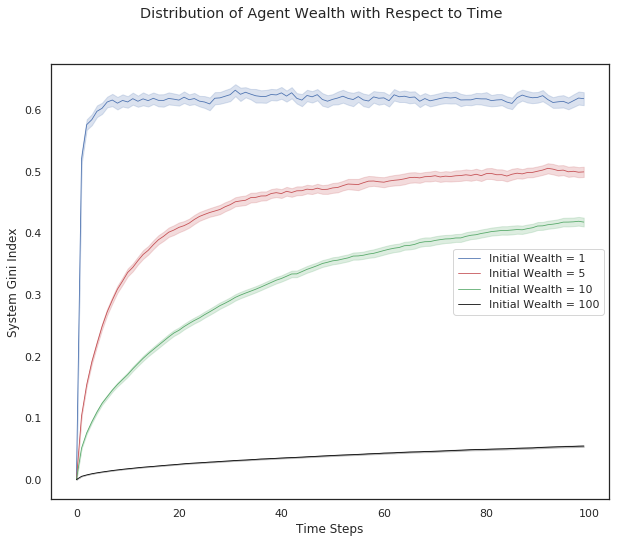

In [24]:
fig = plt.figure(figsize=(10, 8))
sns.set_style("white")

colors = ['b', 'r', 'g', 'black']

for i in range(4):
    # gather into a dataframe
    ginis = pd.DataFrame(model_ginis[i])
    ginis['mean'],  ginis['low'], ginis['high'] = zip(*ginis.apply(mean_confidence_interval,axis=1))

    # plot
    
    plt.fill_between(ginis.index, ginis['low'], ginis['high'], color=colors[i], alpha=.2)
    plt.plot(ginis['mean'],linewidth=0.8,color=colors[i])

    plt.xlabel('Time Steps'); plt.ylabel('System Gini Index'); 
    plt.suptitle('Distribution of Agent Wealth with Respect to Time')

    
legend_titles = [f'Initial Wealth = {c}' for c in initial_wealths]
plt.legend(legend_titles,loc=0)

##### Run for longer time steps (allow to stabilize)

If 100 time steps was not long enough for the high initial wealth models to converge on a steady state, then let's increase it by an order of magnitude (1000 time steps per model)

In [25]:
# initial parameters
initial_wealths = [1,5,10,100]
num_agents = 50
time_steps = 1000
mc_iters = 100

# make tensor keep track of the final wealth of each agent and gini index of each run
# for each initial wealth
agent_wealths = np.zeros((len(initial_wealths),num_agents,mc_iters))
model_ginis = np.zeros((len(initial_wealths),time_steps,mc_iters))


for k in range(len(initial_wealths)):
    initial_wealth = initial_wealths[k]
    for j in range(mc_iters):
        # create a model
        model = Gridless_Model(num_agents,initial_wealth)
        # step through the simulation
        for i in range(time_steps):
            model.step()

        # add the gini index information from each run to an array
        model_ginis[k,:,j] = model.datacollector.get_model_vars_dataframe().Gini.values

        # add the agent wealth distribution to final counts
        agent_wealth = [a.wealth for a in model.schedule.agents]
        agent_wealths[k,:,j]=agent_wealth

**Results (part 2) - longer run time**

Still not much of a change in the histograms (although they are smoother than before). Again, the key difference is that most of the agents in the higher initial wealth models are still able to participate in the system (which might be quite important if this is a key feature of your protocol you're trying to create).

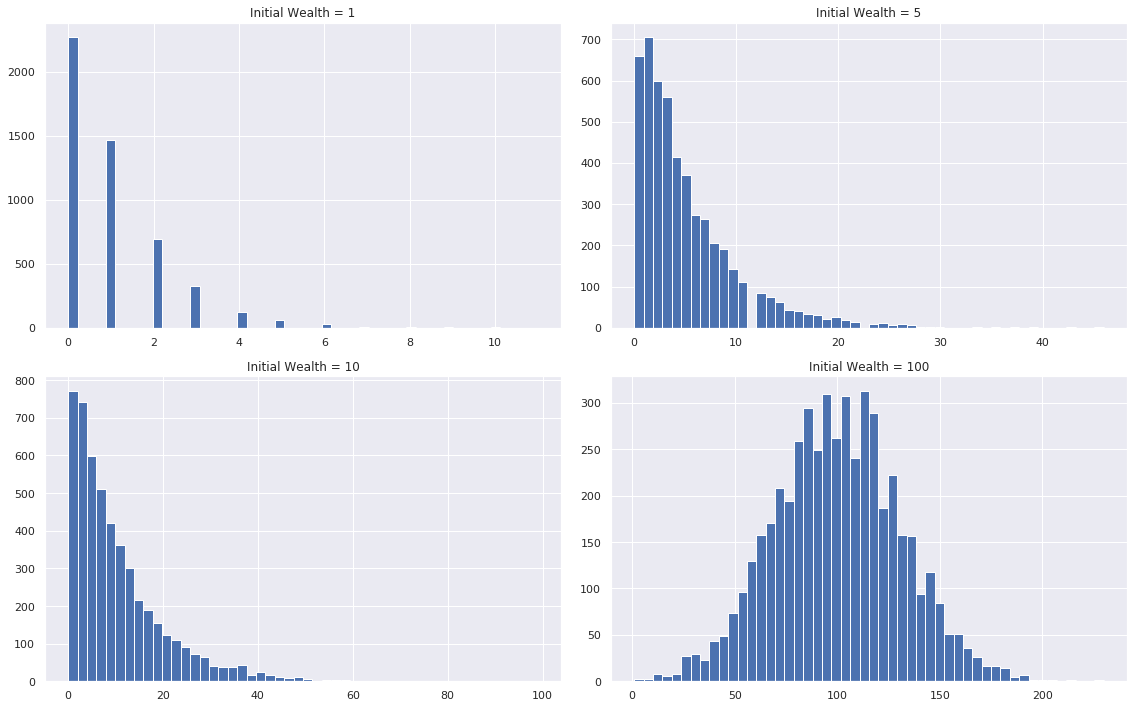

In [26]:
fig = plt.figure(figsize=(16, 10))

sns.set()
for c,num in zip(initial_wealths, range(1,5)):
    wealth = pd.DataFrame(agent_wealths[num-1])
    ax = fig.add_subplot(2,2,num)
    wealth.stack().hist(bins=50)
    ax.set_title(f'Initial Wealth = {c}')
    
plt.tight_layout()

**Gini Index (part 2)**

So now the initial_wealth = 5 and 10 models have reached steady state but we are still waiting for the initial_wealth=100 to do so as well.  We could keep running this but a trend seems to be developing (which could definitely be further investigated if we cared about this system past "for fun's sake") which says that as you increase the initial wealth of the agents, the gini index plateaus lower.  However, at a certain point, it appears that you would hit a limiting bound on this effect.  

That being said, depending on how long you planned for your system to run, a model such as the initial_wealth = 100 does not decay into an unbalanced ecosystem very quickly. If the time period for this is long enough, you may not care about the steady state behavior at all.

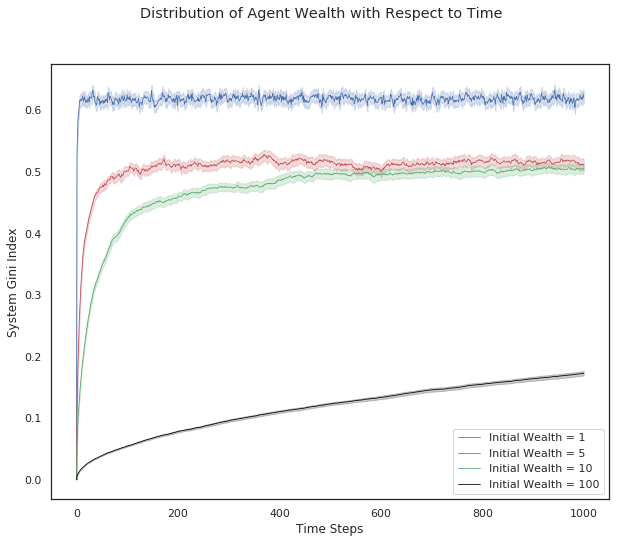

In [27]:
fig = plt.figure(figsize=(10, 8))
sns.set_style("white")

colors = ['b', 'r', 'g', 'black']

for i in range(4):
    # gather into a dataframe
    ginis = pd.DataFrame(model_ginis[i])
    ginis['mean'],  ginis['low'], ginis['high'] = zip(*ginis.apply(mean_confidence_interval,axis=1))

    # plot
    
    plt.fill_between(ginis.index, ginis['low'], ginis['high'], color=colors[i], alpha=.2)
    plt.plot(ginis['mean'],linewidth=0.8,color=colors[i])

    plt.xlabel('Time Steps'); plt.ylabel('System Gini Index'); 
    plt.suptitle('Distribution of Agent Wealth with Respect to Time')

    
legend_titles = [f'Initial Wealth = {c}' for c in initial_wealths]
plt.legend(legend_titles,loc=0)